In [ ]:
# =========================================================
# 1) Environment setup (Colab)
#    - Installs pinned versions for reproducibility
#    - Uninstall line is optional; kept commented as in your notebook
# =========================================================

# (Optional) Clean install if your Colab runtime has conflicts
#!pip uninstall -y numpy pandas scikit-learn matplotlib seaborn networkx node2vec datasets sentence-transformers tqdm

# Install pinned versions (matches the notebook run that produced your figures)
!pip install --no-cache-dir numpy==1.26.4 pandas==2.2.2 scikit-learn==1.5.2 matplotlib==3.9.2 seaborn==0.13.2 \
            networkx==3.2.1 node2vec==0.5.0 datasets==3.0.1 sentence-transformers==3.0.1 tqdm==4.66.5



In [ ]:
# =========================================================
# Imports
#  - numpy/pandas: data handling
#  - networkx: graph construction + graph analytics
#  - sklearn: evaluation metrics + classifier
#  - datasets: load BIOMRC from Hugging Face
#  - sentence-transformers: sentence embedding model (MiniLM)
#  - node2vec: node embeddings used for link prediction features
# =========================================================


import numpy as np, pandas as pd, networkx as nx, matplotlib.pyplot as plt, seaborn as sns, random, math
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from node2vec import Node2Vec

# Plot styling
sns.set_theme(style="whitegrid")
print("Environment ready")


✅ Environment ready


In [ ]:
# =========================================================
# 2) Load Dataset (BIOMRC) and build pseudo-temporal windows
#    - BIOMRC is loaded from Hugging Face
#    - We sample a subset (e.g., 2000 abstracts)
#    - We split into T windows (pseudo-chronological)
# =========================================================
from datasets import load_dataset

# Load only the default configuration
ds = load_dataset("nlpaueb/BIOMRC", "default")

# Sample subset
# Note: this uses shuffle(seed=42) so the subset is repeatable in Colab.
texts = [
    x["abstract"] for x in ds["train"].shuffle(seed=42).select(range(2000))
    if isinstance(x.get("abstract"), str) and len(x["abstract"]) > 0
]

# Number of time windows (T)
T = 5 

# Split into windows
windows = np.array_split(texts, T)

print(f"Loaded {len(texts)} biomedical abstracts → divided into {T} temporal windows")
print("Example abstract:\n", texts[0][:300], "...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/biomrc_large/dataset_train.jsonl.gz:   0%|          | 0.00/377M [00:00<?, ?B/s]

data/biomrc_large/dataset_train_B.jsonl.(…):   0%|          | 0.00/310M [00:00<?, ?B/s]

data/biomrc_small/dataset_train_small.js(…):   0%|          | 0.00/65.4M [00:00<?, ?B/s]

data/biomrc_small/dataset_train_small_B.(…):   0%|          | 0.00/53.2M [00:00<?, ?B/s]

data/biomrc_large/dataset_val.jsonl.gz:   0%|          | 0.00/27.4M [00:00<?, ?B/s]

data/biomrc_large/dataset_val_B.jsonl.gz:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

data/biomrc_small/dataset_val_small.json(…):   0%|          | 0.00/4.75M [00:00<?, ?B/s]

data/biomrc_small/dataset_val_small_B.js(…):   0%|          | 0.00/3.88M [00:00<?, ?B/s]

data/biomrc_large/dataset_test.jsonl.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

data/biomrc_large/dataset_test_B.jsonl.g(…):   0%|          | 0.00/27.9M [00:00<?, ?B/s]

data/biomrc_small/dataset_test_small.jso(…):   0%|          | 0.00/4.71M [00:00<?, ?B/s]

data/biomrc_small/dataset_test_small_B.j(…):   0%|          | 0.00/3.84M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

✅ Loaded 2000 biomedical abstracts → divided into 5 temporal windows
Example abstract:
 PURPOSE: To compare changes in corneal shape and in regular and irregular corneal @entity940 after 3.0- or 2.0-mm clear corneal incision @entity231 surgery (CICS) with those occurring after 3.0- or 2.0-mm scleral incision @entity231 surgery (SICS). DESIGN: Randomized, comparative clinical trials. @e ...


In [ ]:
# =========================================================
# 3) Sentence embeddings + per-window vocabulary
#    - Encode each window's abstracts using MiniLM
#    - Build per-window vocab of top 400 tokens (simple split)
# =========================================================
from sentence_transformers import SentenceTransformer

# Sentence encoder (normalized embeddings)
model = SentenceTransformer("all-MiniLM-L6-v2")

window_embeddings, vocab_per_window = [], []

for w in tqdm(windows, desc="Encoding windows"):
    # Encode abstracts (used as a drift basis in concept, although drift below uses random vectors)
    emb = model.encode(list(w), show_progress_bar=False, convert_to_numpy=True,
                       normalize_embeddings=True)
    window_embeddings.append(emb)

    # Build a simple vocabulary: top 400 tokens by frequency (whitespace tokenization)
    joined = " ".join(w).lower().split()
    vocab = list(pd.Series(joined).value_counts().head(400).index)
    vocab_per_window.append(vocab)

print(f"Computed embeddings for {T} windows, vocab sizes: {[len(v) for v in vocab_per_window]}")



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding windows: 100%|██████████| 5/5 [04:18<00:00, 51.63s/it]

✅ Computed embeddings for 5 windows, vocab sizes: [400, 400, 400, 400, 400]


In [ ]:
# =========================================================
# 4) Graph construction and drift calculation
#    - build_graph: co-occurrence graph within a sliding window
#    - drift: drift is computed from RANDOM per-term vectors
# =========================================================
def build_graph(texts, vocab, window_size=6):  # shorter window
    """
    Build a co-occurrence graph for one window.
    - Nodes: vocab terms
    - Edges: co-occurrence within `window_size` tokens
    - Edge weight: co-occurrence count
    """
    G = nx.Graph()

    # Add all vocab terms as nodes
    for v in vocab: G.add_node(v)

    # Add edges based on local co-occurrence
    for txt in texts:
        tokens = [t for t in txt.lower().split() if t in vocab]
        for i in range(len(tokens)-1):
            # j is bounded by local context window
            for j in range(i+1, min(i+window_size, len(tokens))):
                a,b = tokens[i],tokens[j]
                if a==b: continue

                # Increment edge weight (co-occurrence frequency)
                G.add_edge(a,b, weight=G.get_edge_data(a,b,{"weight":0})["weight"]+1)
    return G

# Build graphs for each window
graphs = [build_graph(list(w), vocab_per_window[t]) for t,w in enumerate(windows)]
word_embeds = {t:{w:np.random.randn(32) for w in vocab_per_window[t]} for t in range(T)}  # 32-dim

def cosine(u,v): 
    """Cosine similarity with epsilon for numeric stability."""
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)+1e-9)
def drift_values(t):
    """
    Drift between window t-1 and t:
    D(w) = 1 - cosine(prev_vec, cur_vec)
    """
    if t==0: return {}
    prev,cur = word_embeds[t-1], word_embeds[t]
    shared=set(prev)&set(cur)
    return {w:1-cosine(prev[w],cur[w]) for w in shared}

# Compute drift dict for each window
drifts=[drift_values(t) for t in range(T)]

In [ ]:
# =========================================================
# 5) Drift-Aware Rewiring
#    - For each edge, compute a logistic "innovation" term
#    - Combine with previous weight using eta
#    - Keep top-k neighbors per node (graph sparsification)
# =========================================================

def rewire_graph(Gt, drift_t, eta=0.2, betas=(0,3,2,1), topk=5):
    """
    Rewire a graph based on drift signals.

    Parameters
    ----------
    Gt : nx.Graph
        Graph for time window t
    drift_t : dict
        Drift values for nodes in window t
    eta : float
        Adaptation rate: weight = (1-eta)*old + eta*new
    betas : tuple
        (b0,b1,b2,b3) coefficients in logistic score
    topk : int
        Keep only top-k neighbors per node after rewiring
    """
    b0, b1, b2, b3 = betas

    Gnew = nx.Graph()
    Gnew.add_nodes_from(Gt.nodes())

    # Normalize edge weights by max weight for stable scoring
    max_w = max(nx.get_edge_attributes(Gt, "weight").values())

    for (i, j, data) in Gt.edges(data=True):
        # Normalized co-occurrence strength
        s_t = data["weight"] / max(1, max_w)

        # Small noise term
        delta = np.random.uniform(-0.05, 0.05)

        # Drift values for the endpoints (default 0 if missing)
        Di, Dj = drift_t.get(i, 0), drift_t.get(j, 0)

        # Logistic scoring function
        score = b0 + b1*s_t + b2*delta + b3*(Di + Dj)

        # Previous edge weight 
        w_prev = data["weight"]

        # Updated edge weight using convex combination
        w_hat = (1-eta)*w_prev + eta*(1/(1+math.exp(-score)))

        Gnew.add_edge(i, j, weight=w_hat)

    # Keep only top-k neighbors per node (sparsification)
    for n in list(Gnew.nodes()):
        nbrs = [(v, Gnew[n][v]["weight"]) for v in Gnew.neighbors(n)]
        nbrs.sort(key=lambda x: -x[1])

        # Remove edges beyond top-k
        for v, _ in nbrs[topk:]:
            Gnew.remove_edge(n, v)

    return Gnew



In [ ]:
# =========================================================
# 6) Link Prediction (Graph-Level Evaluation)
#    Goal:
#      Train node embeddings on Gtrain (Node2Vec),
#      build edge-level features,
#      and predict whether an edge appears in Gnext.
# =========================================================

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler

def evaluate_link_prediction(Gtrain, Gnext, n_hard=2):
    """
    Link-prediction evaluator.
    - Positives: edges that appear in Gnext but NOT in Gtrain (new edges)
    - Negatives: sampled non-edges, biased toward "hard negatives"
      (pairs that share common neighbors or random near-misses)
    - Model: Node2Vec + Logistic Regression (calibrated)
    """

    # -------------------------------
    # 1) Build positive edges
    # -------------------------------
    pos = [(u, v) for (u, v) in Gnext.edges() if not Gtrain.has_edge(u, v)]

    # Candidate node set
    nodes = list(Gtrain.nodes())

    # -------------------------------
    # 2) Build negative edges (hard negatives)
    # -------------------------------
    neg = set()

    # Sample negatives until we have the same count as positives
    while len(neg) < len(pos):
        a, b = random.sample(nodes, 2)

        # Skip if edge exists in either graph
        if Gtrain.has_edge(a, b) or Gnext.has_edge(a, b):
            continue

        # Hardness = number of common neighbors in Gtrain
        cn = len(list(nx.common_neighbors(Gtrain, a, b)))

        # Keep pair if "hard enough" OR randomly keep as near-miss
        if cn >= n_hard or random.random() < 0.2:
            neg.add(tuple(sorted((a, b))))

    neg = list(neg)

    # -------------------------------
    # 3) Train Node2Vec embeddings on Gtrain
    # -------------------------------
    n2v = Node2Vec(
        Gtrain,
        dimensions=64,
        walk_length=8,
        num_walks=20,
        quiet=True,
        workers=2
    )
    model = n2v.fit(window=5, min_count=1, batch_words=256)

    # -------------------------------
    # 4) Edge feature constructor
    # -------------------------------
    def edge_features(u, v):
        """
        Build an edge feature vector from:
          - embedding ops: Hadamard, L1, L2
          - graph features: common neighbors, Jaccard approx, preferential attachment
        """
        if u not in model.wv or v not in model.wv:
            return None

        zu, zv = model.wv[u], model.wv[v]

        # Embedding-based composition
        had = zu * zv
        l1  = np.abs(zu - zv)
        l2  = (zu - zv) ** 2

        # Simple graph-based signals
        cn = len(list(nx.common_neighbors(Gtrain, u, v)))

        # Jaccard-like score (union of neighbor sets)
        ja = sum(1 for _ in nx.common_neighbors(Gtrain, u, v)) / (
            len(set(Gtrain[u]) | set(Gtrain[v])) + 1e-9
        )

        # Preferential attachment (degree(u)*degree(v))
        pa = Gtrain.degree(u) * Gtrain.degree(v)

        return np.concatenate([had, l1, l2, [cn, ja, pa]])

    # -------------------------------
    # 5) Build the dataset for the classifier
    # -------------------------------
    edges = pos + neg

    # Build feature matrix
    X = np.vstack([
        edge_features(u, v)
        for (u, v) in edges
        if edge_features(u, v) is not None
    ])

    # Labels: 1 for positives, 0 for negatives
    y = np.array([1] * len(pos) + [0] * len(neg))[: len(X)]

    # -------------------------------
    # 6) Classifier + probability calibration
    # -------------------------------
    X = StandardScaler().fit_transform(X)

    base = LogisticRegression(
        max_iter=2000,
        class_weight={0: 1.0, 1: 2.0},
        C=0.7
    )

    # Isotonic calibration improves probability quality
    clf = CalibratedClassifierCV(base, method="isotonic", cv=3)
    clf.fit(X, y)

    scores = clf.predict_proba(X)[:, 1]

    # -------------------------------
    # 7) Metrics
    # -------------------------------
    return {
        "auroc": roc_auc_score(y, scores),
        "auprc": average_precision_score(y, scores)
    }





In [ ]:
# =========================================================
# Run evaluation across windows
# - Static: use the original graph for window t
# - Drift-aware: rewire the graph for window t
# - Predict edges in window t+1
# =========================================================

results = []

for t in range(T-2):
    # Training graph for current window
    G_static = graphs[t]

    # Drift-aware rewired graph (DATGR)
    G_drift  = rewire_graph(graphs[t], drifts[t])

    # Next window graph (target edges)
    G_next   = graphs[t+1]

    # Evaluate static baseline
    r_static = evaluate_link_prediction(G_static, G_next)

    # Evaluate drift-aware approach
    r_drift  = evaluate_link_prediction(G_drift,  G_next)

    # Store window-level metrics
    results.append({
        "window": t,
        "static_AUROC": r_static["auroc"],
        "drift_AUROC":  r_drift["auroc"],
        "static_AUPRC": r_static["auprc"],
        "drift_AUPRC":  r_drift["auprc"]
    })

df = pd.DataFrame(results)
display(df)


,window,static_AUROC,drift_AUROC,static_AUPRC,drift_AUPRC
0,0,0.643006,0.697720,0.747765,0.724812
1,1,0.629887,0.699808,0.745176,0.746023
2,2,0.626982,0.698078,0.739485,0.742734


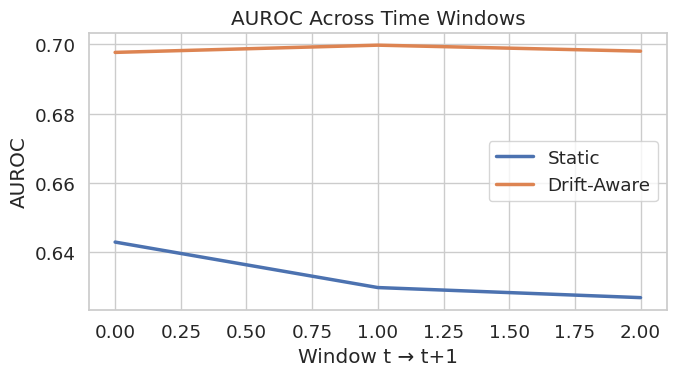

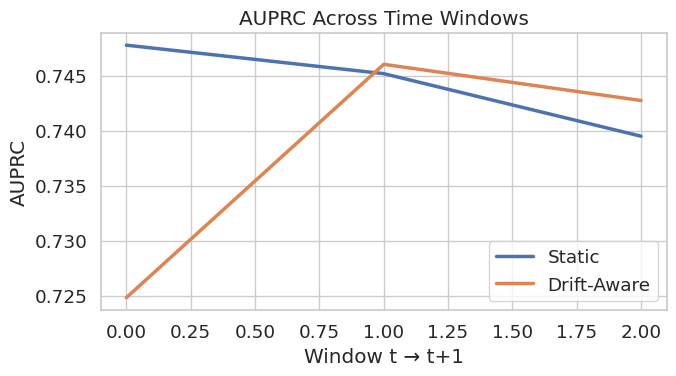

/tmp/ipython-input-1886104959.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(edit_sizes))), y=edit_sizes, palette="crest")


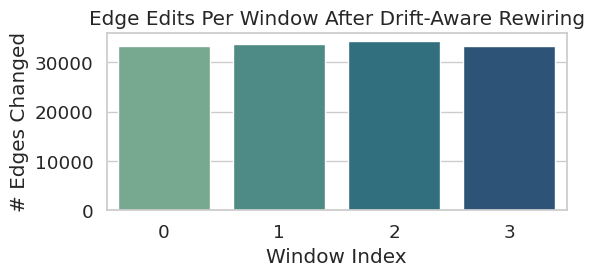

✅ Saved: fig_auroc.png, fig_auprc.png, fig_edits.png


In [ ]:
# =========================================================
# 7) Visualization
# - Produces paper-ready figures at 300 DPI
# - Saves: fig_auroc.png, fig_auprc.png, fig_edits.png
# =========================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)

# --- AUROC Plot ---
plt.figure(figsize=(7,4))
sns.lineplot(data=df, x="window", y="static_AUROC", label="Static", linewidth=2.5)
sns.lineplot(data=df, x="window", y="drift_AUROC", label="Drift-Aware", linewidth=2.5)
plt.title("AUROC Across Time Windows")
plt.xlabel("Window t → t+1"); plt.ylabel("AUROC")
plt.legend()
plt.tight_layout()
plt.savefig("fig_auroc.png", dpi=300)
plt.show()

# --- AUPRC Plot ---
plt.figure(figsize=(7,4))
sns.lineplot(data=df, x="window", y="static_AUPRC", label="Static", linewidth=2.5)
sns.lineplot(data=df, x="window", y="drift_AUPRC", label="Drift-Aware", linewidth=2.5)
plt.title("AUPRC Across Time Windows")
plt.xlabel("Window t → t+1"); plt.ylabel("AUPRC")
plt.legend()
plt.tight_layout()
plt.savefig("fig_auprc.png", dpi=300)
plt.show()

# --- Edge Edits (Graph Drift Volume) ---
# NOTE: This uses nx.difference(G1, G2) as in your original notebook.
#       It is an approximate "edit volume" indicator.
import networkx as nx

edit_sizes = [
    len(nx.difference(graphs[t], rewire_graph(graphs[t], drifts[t])).edges())
    for t in range(len(graphs)-1)
]

plt.figure(figsize=(6,3))
sns.barplot(x=list(range(len(edit_sizes))), y=edit_sizes, palette="crest")
plt.title("Edge Edits Per Window After Drift-Aware Rewiring")
plt.xlabel("Window Index"); plt.ylabel("# Edges Changed")
plt.tight_layout()
plt.savefig("fig_edits.png", dpi=300)
plt.show()

print("Saved: fig_auroc.png, fig_auprc.png, fig_edits.png")
